# The harmonic function method and the mass of some Schwarzschild half-spaces - Computations and Graphs

In this Jupyter Notebook, we will do two main things for our examples from Section 8:
- Compute the lower bound given by Theorem 3.9
- Plot the level sets of the harmonic coordinates

### Setting up the Python environment

In [161]:
# This file is present both as .ipynb as well as .py. For the latter, the `# %%` comment denote borders between cells so the Python file can be treated like an Jupyter notebook as well. The function below checks if the Python file is running inside a Jupyter Notebook
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__ # type: ignore[reportUndefinedVariable]
    if shell in ('ZMQInteractiveShell','XPythonShell','Shell'):
        return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
        return False  # Terminal running IPython
    else:
        return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

In [162]:
if is_notebook():
  get_ipython().run_line_magic("pip", "install gravipy matplotlib scikit-image vegasflow") # this helps if this Notebook is executed from within e.g. jupyter-cloud.gwdg.de  # type: ignore[reportUndefinedVariable]

In [163]:
from gravipy.tensorial import * # import GraviPy package
import sympy
import numpy as np
import scipy
import matplotlib.pyplot as plt

# for plotting of implicit surfaces (i.e. the level sets)
from mpl_toolkits.mplot3d import axes3d
from skimage import measure

from sympy.utilities.lambdify import lambdastr

In [164]:
if is_notebook():
  from IPython.display import display, Markdown
else:
  from rich.markdown import Markdown
  from rich.console import Console
  console = Console()
  display = console.print


### Setting up the manifold, metric, etc.

In [165]:
dim = symbols("n",positive=True,integer=True)

# we use cylindrical coordinates
x1 = symbols("x_1", nonnegative=True)
rho = symbols(r"\rho",nonnegative=True)
phi = symbols(r"\varphi",real=True) # this will be a generic angle variable, in general we have (dim-2) of these
r_critical = symbols(r"r_0",positive=True)
# r_critical = (m/2)**(1/(dim-2))

r=sympy.sqrt(rho**2+x1**2)
coords=[x1,rho,phi]
pos = Coordinates(r'\chi',coords)
omega=(1+(r_critical/r)**(dim-2))
exponent=sympy.Number(4)/(dim-2)
# metric = sympy.MatrixSymbol("g",3,3)
metric = omega**exponent*sympy.diag(1,1,rho**2)
g = MetricTensor('g', pos, metric)
Ga = Christoffel(r'\Gamma', g)

In [166]:
# useful for all kinds of integrals
volume_element = (omega**(exponent*dim/2)).simplify()
hypersurface_volume_element = (omega**(exponent*(dim-1)/2)).simplify()

In [167]:
# metric of hypersurface
# gamma_metric = omega**exponent*sympy.diag(*([0]+[1]*(dim-1)))
# gamma = MetricTensor(r'\gamma', pos, gamma_metric)
# Ga_gamma = Christoffel(r'\Gamma_{\gamma}',gamma)

Some utility functions:

In [168]:
# as long as scalar is rotationally symmetric (wrt the x1-axis), this should work
def laplacian(scalar):
  return g(-1,-1)*scalar.covariantD(1,1) + g(-2,-2)*scalar.covariantD(2,2) + (dim-2)*g(-3,-3)*scalar.covariantD(3,3)

### Setting up the harmonic coordinates

Define all the harmonic coordinates for $M_{m,+}$:

In [169]:
u1 = Tensor("u_1",0,g)

def u1_method(idxs):
    component = x1*(1+(r_critical/r)**dim)/omega
    u1.components.update({idxs: component})
    return component

u1._compute_covariant_component = u1_method

And define $u_1$ for the modified Schwarzschild space $M_{m,\geq a}$ for $a>0$:

In [170]:
a = symbols("a")
u1_modified = Tensor("u_1",0,g)

def u1_modified_method(idxs):
    component = (x1+a*(r_critical/r)**(dim-2))/omega
    u1_modified.components.update({idxs: component})
    return component
u1_modified._compute_covariant_component = u1_modified_method

In [171]:
dim_over_3=symbols(r"\tilde{n}", nonnegative=True)

## Testing our Setup

### What's the mass of our space?

We use the spherical symmetry of the solution to avoid the integral, but we do evaluate the integrand in one radial direction (namely along the $x_1$-axis)

In [172]:
normal_vector_to_sphere = Tensor(r"n_{S_r}",1,g)
def n_S_r_compute_covariant_component(idxs):
  if idxs[0]!=3:
      component = sympy.sqrt(g(idxs[0],idxs[0]))*coords[idxs[0]-1]/r
  else:
      component = 0
  normal_vector_to_sphere.components.update({idxs:component})
  return component
normal_vector_to_sphere._compute_covariant_component=n_S_r_compute_covariant_component

In [173]:
normal_vector_to_sphere(-All)

Matrix([[x_1*sqrt(((r_0/sqrt(\rho**2 + x_1**2))**(n - 2) + 1)**(4/(n - 2)))/(sqrt(\rho**2 + x_1**2)*((r_0/sqrt(\rho**2 + x_1**2))**(n - 2) + 1)**(4/(n - 2))), \rho*sqrt(((r_0/sqrt(\rho**2 + x_1**2))**(n - 2) + 1)**(4/(n - 2)))/(sqrt(\rho**2 + x_1**2)*((r_0/sqrt(\rho**2 + x_1**2))**(n - 2) + 1)**(4/(n - 2))), 0]])

In [174]:
# if either i or j are angle coordinates this will be zero (since we look along x1=0)
# to compensate for the missing dimensions, we multiply by (dim-1)
# this is all just guesswork, TODO to improve this
mass_integrand = (dim-1)*sum((g.partialD(i,j,i)-g.partialD(i,i,j))*normal_vector_to_sphere(-j) for i,j in list(variations(range(1,4),2,True)))
ray_substition = [[rho,0]] # our coordinates are singular here
ray_mass_integrand = mass_integrand.subs(ray_substition).simplify()

In [175]:
ray_mass_integrand

4*r_0**(n - 2)*x_1**(1 - n)*(n - 1)*sqrt((r_0**(n - 2)*x_1**(2 - n) + 1)**(4/(n - 2)))/(r_0**(n - 2)*x_1**(2 - n) + 1)

Here and in the following we will need the area of an $(n-1)$-sphere

In [176]:
sphere_volume = 2*sympy.pi ** (dim / 2) / sympy.gamma(dim / 2)
normalization = 1 / (sphere_volume * 2 * (dim - 1))

In [177]:
normalization

gamma(n/2)/(4*pi**(n/2)*(n - 1))

In [178]:
# volume element not strictly needed since we could also use euclidean background metric
dim_over_2=symbols(r"\tilde{n}",positive=True)
unnormalized_mass_integral = (ray_mass_integrand*hypersurface_volume_element*(sphere_volume/2*r**(dim-1)).subs(ray_substition)).simplify().subs([[dim,dim_over_2+2]])
unnormalized_mass = sympy.Limit(unnormalized_mass_integral,x1,sympy.oo).simplify().subs([[dim_over_2,dim-2]]).simplify()
mass = (normalization*unnormalized_mass).subs([[dim,dim_over_2+2]]).simplify().subs([[dim_over_2,dim-2]])

In [179]:
mass

r_0**(n - 2)

The following should return $m/2=r_0^{n-2}$, where $n$ is the dimension.

In [180]:
display(Markdown(f"The mass is ${sympy.latex(mass)}$"))
assert(mass==(r_critical**(dim-2)).simplify())

The mass is $r_{0}^{n - 2}$

### Is the mean curvature correct?

We compute the mean curvature of the noncompact boundary (observe that the result agrees with our computation in Section 8)

In [181]:
normal_vector_to_noncompact_boundary = Tensor(r"\nu",1,g)
def nu_compute_covariant_component(idxs):
  if idxs[0]==1:
    component = -sympy.sqrt(g(1,1))
  else:
     component = sympy.Number(0)
  normal_vector_to_noncompact_boundary.components.update({idxs:component})
  return component
normal_vector_to_noncompact_boundary._compute_covariant_component=nu_compute_covariant_component

In [182]:
# we multiply by (dim-2) whenever i and j are equal to 3 (note that when only one of i or j is equal to 3, the summand below is zero)
H=sympy.powdenest(sum((dim-2 if i==3 and j==3 else 1) *g(-i,-j)*normal_vector_to_noncompact_boundary.covariantD(i,j) for i,j in variations(range(1,4),2,True)).simplify(),force=True)
display(Markdown(f"Mean curvature $H$ of non-compact boundary is ${sympy.latex(H)}$, which is the same as $\\frac{{2 (n-1)r_0^{{n-2}}}}{{r^n\\cdot \omega^{{2/(n-2)+1}}}}x_1={sympy.latex((2*(dim-1)*r_critical**(dim-2)*x1/(r**dim*omega**(sympy.Number(2)/(dim-2)+1))).simplify())}$."))
assert((H-2*(dim-1)*r_critical**(dim-2)*x1/(r**dim*omega**(sympy.Number(2)/(dim-2)+1))).simplify()==0)

Mean curvature $H$ of non-compact boundary is $2 r_{0}^{n - 2} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{- \frac{n}{2}} \left(n - 1\right) \left(r_{0}^{n - 2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} + 1\right)^{- \frac{n}{n - 2}}$, which is the same as $\frac{2 (n-1)r_0^{n-2}}{r^n\cdot \omega^{2/(n-2)+1}}x_1=2 r_{0}^{n - 2} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{- \frac{n}{2}} \left(n - 1\right) \left(r_{0}^{n - 2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} + 1\right)^{- \frac{n}{n - 2}}$.

The above is greater than $0$ in particular if $x_1>0$.

### Are our functions truly harmonic?

In [183]:
laplacian_u1=laplacian(u1)
laplacian_u1_modified = laplacian(u1_modified)

In [184]:
# somehow the simplification seems to fail in general dimension, but it seems that our general computations are correct
min_dim=3
max_dim=11
laplacians_in_different_dims = []
display(Markdown(f"Harmonicity check of $u_1$ for dimensions ${min_dim}$ to ${max_dim-1}$:"))
for n in range(min_dim,max_dim):
    laplacians_in_different_dims.append(laplacian_u1.subs([[dim,n]]).simplify())
print(laplacians_in_different_dims)

Harmonicity check of $u_1$ for dimensions $3$ to $10$:

[0, 0, 0, 0, 0, 0, 0, 0]


In [185]:
# somehow the simplification seems to fail in general dimension, but it seems that our general computations are correct
laplacians_in_different_dims = []
min_dim
display(Markdown(f"Harmonicity check of $\\tilde{{u}}_1$ (on $M_{{m,\\geq a}}$ for dimensions ${min_dim}$ to ${max_dim-1}$:"))
for n in range(min_dim,max_dim):
    laplacians_in_different_dims.append(laplacian_u1_modified.subs([[dim,n]]).simplify())
print(laplacians_in_different_dims)

Harmonicity check of $\tilde{u}_1$ (on $M_{m,\geq a}$ for dimensions $3$ to $10$:

[0, 0, 0, 0, 0, 0, 0, 0]


### Are the boundary conditions truly fulfilled?

For $a=0$ we should in particular have $\partial_r u_i\vert_{r=r_0}=0$:

In [186]:
radial_derivative = sum(u1.covariantD(i+1)*coords[i] for i in range(2))
substitution = [x1,sympy.sqrt(r_critical**2-rho**2)]
radial_derivative_substituted = radial_derivative.subs([substitution]).simplify()
display(Markdown(f"$\partial_r u_{1}\\vert_{{r=r_0}}={sympy.latex(radial_derivative_substituted)}$"))
assert(radial_derivative_substituted==0)

$\partial_r u_1\vert_{r=r_0}=0$

For $a>0$, we should have $\tilde{u}_1\vert_{x_1=a}=a$:

In [187]:
u1_modified_at_x1_equal_a=u1_modified().subs([[x1,a]]).simplify()
display(Markdown(f"$\\tilde{{u}}_1\\vert_{{x_1=a}}={u1_modified_at_x1_equal_a}$"))
assert(u1_modified_at_x1_equal_a==a)

$\tilde{u}_1\vert_{x_1=a}=a$

### Are there any critical points?

It is interesting to consider whether there are any critical points of $u_3$ to be able to discuss how strong the lower bound given by our technique is (see Remark 4.3).

##### For $M_{m,+}$ there is at least one (at $\rho=0$, $x_1=r_0$):

In [188]:
display(
    Markdown(
        f"On $M_{{m,+}}$, there is at least one critical point: At $(0,0,r_0)$ we have $\operatorname{{grad}} u_1={sympy.latex(sympy.Array([u1.covariantD(i) for i in range(1,4)]).subs(([(x1,r_critical),(rho,0)])).simplify())}$ (note that the last component here stands for the identical $n-2$ angular derivatives)."
    )
)

On $M_{m,+}$, there is at least one critical point: At $(0,0,r_0)$ we have $\operatorname{grad} u_1=\left[\begin{matrix}0 & 0 & 0\end{matrix}\right]$ (note that the last component here stands for the identical $n-2$ angular derivatives).

##### For $M_{m,\geq a}$:

In [189]:
relevant_derivative = u1_modified.covariantD(1).simplify()
only_numerator = sympy.fraction(relevant_derivative)[0].expand()
display(Markdown(f"""On $M_{{m,\geq a}}$ (for $a>0$), $u_1$ has no critical points!

It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1={sympy.latex(relevant_derivative)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator ${sympy.latex(only_numerator)}$.

But $x_1\geq a > 0$ and $n\geq 1$ and thus the negative terms are balanced out by the other terms."""))

On $M_{m,\geq a}$ (for $a>0$), $u_1$ has no critical points!

It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1=\frac{r_{0}^{n - 2} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} \left(n - 2\right) \left(a r_{0}^{n - 2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} + x_{1}\right) + \left(r_{0}^{n - 2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} + 1\right) \left(\rho^{2} - a r_{0}^{n - 2} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} \left(n - 2\right) + x_{1}^{2}\right)}{\left(\rho^{2} + x_{1}^{2}\right) \left(r_{0}^{n - 2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}} + 1\right)^{2}}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator $\rho^{2} + \frac{\rho^{2} r_{0}^{n} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}}}{r_{0}^{2}} - \frac{a n r_{0}^{n} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}}}{r_{0}^{2}} + \frac{2 a r_{0}^{n} x_{1} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}}}{r_{0}^{2}} + \frac{n r_{0}^{n} x_{1}^{2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}}}{r_{0}^{2}} + x_{1}^{2} - \frac{r_{0}^{n} x_{1}^{2} \left(\rho^{2} + x_{1}^{2}\right)^{1 - \frac{n}{2}}}{r_{0}^{2}}$.

But $x_1\geq a > 0$ and $n\geq 1$ and thus the negative terms are balanced out by the other terms.

## Computation of the lower bound

Let's try to compute the lower bound for the mass. We avoid simplifying anything (I once tried to let `sympy` simplify `abs_hessian_u1`, and it did complete, but only after 10 hours!). Even with manual help factoring out $\omega$ terms and the like, the computation times are still often in the minutes. The numerical integration later on is fast enough to deal with unoptimized expressions.

In [190]:
abs_nabla_u1=sympy.sqrt(sum(g(-i,-j)*u1.covariantD(i)*u1.covariantD(j) for i in range(1,3) for j in range(1,3))) # there is no angular component

In [191]:
abs_nabla_u1_modified=sympy.sqrt(sum(g(-i,-j)*u1_modified.covariantD(i)*u1_modified.covariantD(j) for i in range(1,3) for j in range(1,3)))

In [192]:
# either i=j=k=l=3 or none of i,j,k,l are equal to 3, all other terms are zero
abs_hessian_u1=sympy.sqrt(sum((dim-2 if i==3 else 1)*g(-i,-k)*g(-j,-l)*u1.covariantD(i,j)*u1.covariantD(k,l) for i,j,k,l in list(variations(range(1, 4), 4, True))))

In [193]:
abs_hessian_u1_modified=sympy.sqrt(sum((dim-2 if i==3 else 1)*g(-i,-k)*g(-j,-l)*u1_modified.covariantD(i,j)*u1_modified.covariantD(k,l) for i,j,k,l in variations(range(1, 3), 4, True)))

We can now express the integrands. Note that we need to include the volume element. Also we have $R=0$, so the second term in the integrand disappears

In [194]:
lower_bound_integrand_over_M=(abs_hessian_u1**2/abs_nabla_u1)*volume_element
lower_bound_modified_integrand_over_M=((abs_hessian_u1_modified**2/abs_nabla_u1_modified)*volume_element)

We can now also write down the expression for the integral term on the boundary (we need to use the volume element of $\Sigma$ here). Note that the integrand over the boundary vanishes for $M_{m,+}$.

In [195]:
lower_bound_integrand_over_boundary = 2*(H.subs(x1,0).simplify()*abs_nabla_u1)*hypersurface_volume_element
print(f"{lower_bound_integrand_over_boundary=}")
assert(lower_bound_integrand_over_boundary==0)

lower_bound_modified_integrand_over_boundary = 2*(H.subs(x1,a).simplify()*abs_nabla_u1_modified)*hypersurface_volume_element

lower_bound_integrand_over_boundary=0


We use `sympy.lambdify` to get numerical expressions for our integrands.

In [196]:
import tensorflow as tf

# numerical implementation (reverse args as we want x1 integration to be outermost)
args = [rho,x1,r_critical,a,dim]

num_lower_bound_integrand_over_M = sympy.lambdify(args,lower_bound_integrand_over_M,modules=tf)
num_lower_bound_integrand_over_boundary = sympy.lambdify(args,lower_bound_integrand_over_boundary,modules=tf)

# and we shift this one integrand so that the integral will be centered at 0
num_lower_bound_modified_integrand_over_M = sympy.lambdify(
    args, lower_bound_modified_integrand_over_M.subs(x1,x1+a),modules=tf
)
num_lower_bound_modified_integrand_over_boundary = sympy.lambdify(
    args, lower_bound_modified_integrand_over_boundary,modules=tf
)

We can now do the numerical integration. Due to symmetry we are able to only integrate over one quadrant ($x_2\geq 0, \dotsc, x_n\geq 0$ in addition to the usual $x_1\geq 0$) and multiply by $2^{n-1}$ afterwards.

In [197]:
from vegasflow import VegasFlowPlus
from vegasflow.utils import generate_condition_function
from vegasflow.configflow import DTYPE
or_cond = generate_condition_function(2,condition="or")
from functools import cache


def make_integrand(expr, r_critical_value, a_value, extra_args):

  # Convert extra_args to a TensorFlow tensor
  extra_args_tensor = tf.convert_to_tensor(extra_args, dtype=DTYPE)
  if (len(extra_args)==3): # manifold integral
    def integrand(xarr):

      outside_horizon = tf.norm(xarr,axis=1)>r_critical_value
      a_nonzero_cond = xarr[:,0]*0+a_value>0
      mask,idx = or_cond(outside_horizon,a_nonzero_cond)
      masked_xarr = tf.boolean_mask(xarr, mask, axis=0)

      x1 = masked_xarr[:,0]
      rho = tf.norm(masked_xarr[:,1:],axis=1)



      # Reshape extra_args to have shape (1, extra_args_size)
      extra_args_expanded = tf.expand_dims(extra_args_tensor, axis=0)

      # Broadcast extra_args along the batch dimension to match the batch size of xarr
      extra_args_broadcasted = tf.tile(extra_args_expanded, [tf.shape(masked_xarr)[0], 1])


      result = expr(rho,x1,*tf.unstack(extra_args_broadcasted,axis=1))
      # Return a sparse tensor so that only the actual results have a value
      return tf.scatter_nd(idx, result,shape=tf.shape(outside_horizon))

  else: # boundary integral
    def integrand(xarr):
      rho = tf.norm(xarr,axis=1)

      # Reshape extra_args to have shape (1, extra_args_size)
      extra_args_expanded = tf.expand_dims(extra_args_tensor, axis=0)

      # Broadcast extra_args along the batch dimension to match the batch size of xarr
      extra_args_broadcasted = tf.tile(extra_args_expanded, [tf.shape(xarr)[0], 1])


      result = expr(rho,*tf.unstack(extra_args_broadcasted,axis=1))
      # Return a sparse tensor so that only the actual results have a value
      return result

  return integrand



def make_vegas_instance(expr,integration_dim, r_critical_value, a_value, extra_args,n_calls = int(1e6),box_size=1e5):
  vegas_instance = VegasFlowPlus(integration_dim, n_calls, xmin=[0]*integration_dim,xmax=[box_size]*integration_dim)
  integrand = make_integrand(expr, r_critical_value, a_value, extra_args)
  vegas_instance.compile(integrand)
  return vegas_instance


In [198]:
from collections import namedtuple
LowerBoundResult = namedtuple("LowerBoundResult",["total_lower_bound","total_error",
            "lower_bound_M",
            "error_M",
            "lower_bound_boundary",
            "error_boundary"])


class LowerBoundCalculator:
  def __init__(self,r_critical_value=1,a_value=0,dim_value=4,box_size=1e4,n_calls=int(1e6)):
    self.a_value=a_value
    self.total_iters=0
    self.last_result=None
    self.dim_value=dim_value
    self.normalization = float(normalization.subs([[dim,self.dim_value]]))
    self.number_quadrants = 2**(self.dim_value-1)
    if a_value!=0:
      manifold_expr = num_lower_bound_modified_integrand_over_M
      boundary_expr = num_lower_bound_modified_integrand_over_boundary
    else:
      manifold_expr = num_lower_bound_integrand_over_M
      boundary_expr = num_lower_bound_integrand_over_boundary
    self.manifold_integrator = make_vegas_instance(
      expr=manifold_expr,
      integration_dim=dim_value,
      r_critical_value=r_critical_value,
      a_value=a_value,extra_args=[r_critical_value,a_value,dim_value],
      n_calls=n_calls,
      box_size=box_size
    )
    if a_value!=0:
      # here we pass an additional extra arg to set x1 to a_value
      self.boundary_integrator = make_vegas_instance(
        expr=boundary_expr,
        integration_dim=dim_value-1,
        r_critical_value=r_critical_value,
        a_value=a_value,
        extra_args=[a_value,r_critical_value,a_value,dim_value],
        n_calls=n_calls,
        box_size=box_size
      )
    return

  def train_until(self,n_iter):
    if n_iter<=self.total_iters:
      return self.last_result
    else:
      return self.run_integration(n_iter=int(n_iter-self.total_iters))

  def run_integration(self,n_iter=1):
    result_on_M = self.manifold_integrator.run_integration(n_iter)
    if self.a_value!=0:
      result_on_boundary = self.boundary_integrator.run_integration(n_iter)
    else:
      result_on_boundary = [0,0] # we know that the boundary integrand is zero for the a=0 case
    self.total_iters += n_iter
    lower_bound_M = self.normalization*self.number_quadrants * result_on_M[0]
    lower_bound_boundary = self.normalization*self.number_quadrants * result_on_boundary[0]
    error_M = self.normalization*self.number_quadrants * result_on_M[1]
    error_boundary = self.normalization*self.number_quadrants * result_on_boundary[1]
    total_lower_bound = lower_bound_M + lower_bound_boundary
    total_error = error_M + error_boundary
    result = LowerBoundResult(
      total_lower_bound,
      total_error,
      lower_bound_M,
      error_M,
      lower_bound_boundary,
      error_boundary,
    )
    self.last_result = result
    return result

In [199]:
CalculationParams = namedtuple("CalculationParams",["r_critical_value","a_value","dim_value","box_size","n_calls"])

In [200]:
LowerBoundCalculatorDict = dict()

In [201]:
def getLowerBoundCalculator(r_critical_value=1,a_value=0,dim_value=4,box_size=1e4,n_calls=int(1e6)):
  calc_params = CalculationParams(r_critical_value=r_critical_value,a_value=a_value,dim_value=dim_value,box_size=box_size,n_calls=n_calls)
  if calc_params in LowerBoundCalculatorDict:
    return LowerBoundCalculatorDict[calc_params]
  else:
    result = LowerBoundCalculator(r_critical_value=r_critical_value,a_value=a_value,dim_value=dim_value,box_size=box_size,n_calls=n_calls)
    LowerBoundCalculatorDict[calc_params]=result
    return result

We use the smart VEGAS algorithm (optionally even on GPU!) and this solves our speed problems. Though we choose a small box size to help it focus on the difficult part of the integral

In [202]:
num_lower_bound_integrand_over_M(*tf.unstack(tf.convert_to_tensor([1,0.1,1,0,8],dtype=DTYPE)))

<tf.Tensor: shape=(), dtype=float64, numpy=1.7011269829327866>

In [224]:
dim_value = 8
r_critical_value=1

In [225]:
a_equal_0_case = getLowerBoundCalculator(a_value=0,box_size=2e1,r_critical_value=1,n_calls=1e6,dim_value=dim_value)

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
INFO:vegasflow.vflowplus:Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
INFO:vegasflow.monte_carlo:Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)


In [226]:
_ = a_equal_0_case.train_until(n_iter=100) # train the integrator

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.775e-04 +/- 7.419e-05(took 1.62704 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 1.775e-04 +/- 7.419e-05(took 1.62704 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.3268 +/- 0.1864(took 0.62910 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 0.3268 +/- 0.1864(took 0.62910 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 0.7860 +/- 0.1313(took 0.67323 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 0.7860 +/- 0.1313(took 0.67323 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 0.6890 +/- 0.0073(took 1.01251 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 0.6890 +/- 0.0073(took 1.01251 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 0.6913 +/- 0.0019(took 0.92286 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 0.6913 +/- 0.0019(took 0.92286 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 0.6976 +/- 0.0032(took 0.82893 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 0.6976 +/- 0.0032(took 0.82893 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 0.6967 +/- 0.0029(took 0.69546 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 0.6967 +/- 0.0029(took 0.69546 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: 0.6996 +/- 0.0027(took 0.66740 s)
INFO:vegasflow.monte_carlo:Result for iteration 7: 0.6996 +/- 0.0027(took 0.66740 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: 0.6984 +/- 0.0023(took 0.74928 s)
INFO:vegasflow.monte_carlo:Result for iteration 8: 0.6984 +/- 0.0023(took 0.74928 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: 0.6961 +/- 0.0013(took 0.73613 s)
INFO:vegasflow.monte_carlo:Result for iteration 9: 0.6961 +/- 0.0013(took 0.73613 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 10: 0.6972 +/- 0.0013(took 0.67897 s)
INFO:vegasflow.monte_carlo:Result for iteration 10: 0.6972 +/- 0.0013(took 0.67897 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 11: 0.6985 +/- 0.0012(took 0.73693 s)
INFO:vegasflow.monte_carlo:Result for iteration 11: 0.6985 +/- 0.0012(took 0.73693 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 12: 0.6971 +/- 0.0013(took 0.62897 s)
INFO:vegasflow.monte_carlo:Result for iteration 12: 0.6971 +/- 0.0013(took 0.62897 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 13: 0.7003 +/- 0.0017(took 0.62174 s)
INFO:vegasflow.monte_carlo:Result for iteration 13: 0.7003 +/- 0.0017(took 0.62174 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 14: 0.7002 +/- 0.0016(took 0.69212 s)
INFO:vegasflow.monte_carlo:Result for iteration 14: 0.7002 +/- 0.0016(took 0.69212 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 15: 0.6985 +/- 0.0014(took 0.69643 s)
INFO:vegasflow.monte_carlo:Result for iteration 15: 0.6985 +/- 0.0014(took 0.69643 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 16: 0.6995 +/- 0.0015(took 0.60885 s)
INFO:vegasflow.monte_carlo:Result for iteration 16: 0.6995 +/- 0.0015(took 0.60885 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 17: 0.6989 +/- 0.0014(took 0.68092 s)
INFO:vegasflow.monte_carlo:Result for iteration 17: 0.6989 +/- 0.0014(took 0.68092 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 18: 0.6957 +/- 0.0013(took 0.70961 s)
INFO:vegasflow.monte_carlo:Result for iteration 18: 0.6957 +/- 0.0013(took 0.70961 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 19: 0.6993 +/- 0.0022(took 0.76163 s)
INFO:vegasflow.monte_carlo:Result for iteration 19: 0.6993 +/- 0.0022(took 0.76163 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 20: 0.6972 +/- 0.0021(took 1.08082 s)
INFO:vegasflow.monte_carlo:Result for iteration 20: 0.6972 +/- 0.0021(took 1.08082 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 21: 0.6970 +/- 0.0013(took 0.99121 s)
INFO:vegasflow.monte_carlo:Result for iteration 21: 0.6970 +/- 0.0013(took 0.99121 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 22: 0.6995 +/- 0.0013(took 0.86691 s)
INFO:vegasflow.monte_carlo:Result for iteration 22: 0.6995 +/- 0.0013(took 0.86691 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 23: 0.6960 +/- 0.0013(took 0.71560 s)
INFO:vegasflow.monte_carlo:Result for iteration 23: 0.6960 +/- 0.0013(took 0.71560 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 24: 0.7013 +/- 0.0017(took 0.63974 s)
INFO:vegasflow.monte_carlo:Result for iteration 24: 0.7013 +/- 0.0017(took 0.63974 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 25: 0.6979 +/- 0.0017(took 0.70709 s)
INFO:vegasflow.monte_carlo:Result for iteration 25: 0.6979 +/- 0.0017(took 0.70709 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 26: 0.6954 +/- 0.0013(took 0.67279 s)
INFO:vegasflow.monte_carlo:Result for iteration 26: 0.6954 +/- 0.0013(took 0.67279 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 27: 0.7005 +/- 0.0014(took 0.67919 s)
INFO:vegasflow.monte_carlo:Result for iteration 27: 0.7005 +/- 0.0014(took 0.67919 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 28: 0.6993 +/- 0.0013(took 0.62429 s)
INFO:vegasflow.monte_carlo:Result for iteration 28: 0.6993 +/- 0.0013(took 0.62429 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 29: 0.6957 +/- 0.0015(took 0.70437 s)
INFO:vegasflow.monte_carlo:Result for iteration 29: 0.6957 +/- 0.0015(took 0.70437 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 30: 0.6950 +/- 0.0015(took 0.78555 s)
INFO:vegasflow.monte_carlo:Result for iteration 30: 0.6950 +/- 0.0015(took 0.78555 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 31: 0.6974 +/- 0.0014(took 0.67151 s)
INFO:vegasflow.monte_carlo:Result for iteration 31: 0.6974 +/- 0.0014(took 0.67151 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 32: 0.7027 +/- 0.0038(took 0.64370 s)
INFO:vegasflow.monte_carlo:Result for iteration 32: 0.7027 +/- 0.0038(took 0.64370 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 33: 0.6922 +/- 0.0031(took 0.64750 s)
INFO:vegasflow.monte_carlo:Result for iteration 33: 0.6922 +/- 0.0031(took 0.64750 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 34: 0.6968 +/- 0.0015(took 0.73023 s)
INFO:vegasflow.monte_carlo:Result for iteration 34: 0.6968 +/- 0.0015(took 0.73023 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 35: 0.7006 +/- 0.0018(took 0.63688 s)
INFO:vegasflow.monte_carlo:Result for iteration 35: 0.7006 +/- 0.0018(took 0.63688 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 36: 0.6985 +/- 0.0017(took 0.65475 s)
INFO:vegasflow.monte_carlo:Result for iteration 36: 0.6985 +/- 0.0017(took 0.65475 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 37: 0.6977 +/- 0.0025(took 0.96226 s)
INFO:vegasflow.monte_carlo:Result for iteration 37: 0.6977 +/- 0.0025(took 0.96226 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 38: 0.6989 +/- 0.0023(took 0.99509 s)
INFO:vegasflow.monte_carlo:Result for iteration 38: 0.6989 +/- 0.0023(took 0.99509 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 39: 0.6975 +/- 0.0013(took 0.99942 s)
INFO:vegasflow.monte_carlo:Result for iteration 39: 0.6975 +/- 0.0013(took 0.99942 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 40: 0.6968 +/- 0.0017(took 0.66230 s)
INFO:vegasflow.monte_carlo:Result for iteration 40: 0.6968 +/- 0.0017(took 0.66230 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 41: 0.6979 +/- 0.0017(took 0.70522 s)
INFO:vegasflow.monte_carlo:Result for iteration 41: 0.6979 +/- 0.0017(took 0.70522 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 42: 0.6962 +/- 0.0013(took 0.67255 s)
INFO:vegasflow.monte_carlo:Result for iteration 42: 0.6962 +/- 0.0013(took 0.67255 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 43: 0.6993 +/- 0.0016(took 0.72103 s)
INFO:vegasflow.monte_carlo:Result for iteration 43: 0.6993 +/- 0.0016(took 0.72103 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 44: 0.6979 +/- 0.0016(took 0.73605 s)
INFO:vegasflow.monte_carlo:Result for iteration 44: 0.6979 +/- 0.0016(took 0.73605 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 45: 0.6978 +/- 0.0013(took 0.69416 s)
INFO:vegasflow.monte_carlo:Result for iteration 45: 0.6978 +/- 0.0013(took 0.69416 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 46: 0.6985 +/- 0.0013(took 0.78357 s)
INFO:vegasflow.monte_carlo:Result for iteration 46: 0.6985 +/- 0.0013(took 0.78357 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 47: 0.6965 +/- 0.0013(took 0.67999 s)
INFO:vegasflow.monte_carlo:Result for iteration 47: 0.6965 +/- 0.0013(took 0.67999 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 48: 0.6962 +/- 0.0012(took 0.67711 s)
INFO:vegasflow.monte_carlo:Result for iteration 48: 0.6962 +/- 0.0012(took 0.67711 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 49: 0.6978 +/- 0.0015(took 0.79923 s)
INFO:vegasflow.monte_carlo:Result for iteration 49: 0.6978 +/- 0.0015(took 0.79923 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 50: 0.6988 +/- 0.0020(took 0.72511 s)
INFO:vegasflow.monte_carlo:Result for iteration 50: 0.6988 +/- 0.0020(took 0.72511 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 51: 0.6982 +/- 0.0018(took 0.71107 s)
INFO:vegasflow.monte_carlo:Result for iteration 51: 0.6982 +/- 0.0018(took 0.71107 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 52: 0.7003 +/- 0.0023(took 0.72636 s)
INFO:vegasflow.monte_carlo:Result for iteration 52: 0.7003 +/- 0.0023(took 0.72636 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 53: 0.7034 +/- 0.0022(took 0.70767 s)
INFO:vegasflow.monte_carlo:Result for iteration 53: 0.7034 +/- 0.0022(took 0.70767 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 54: 0.6988 +/- 0.0013(took 1.15855 s)
INFO:vegasflow.monte_carlo:Result for iteration 54: 0.6988 +/- 0.0013(took 1.15855 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 55: 0.6979 +/- 0.0013(took 0.99021 s)
INFO:vegasflow.monte_carlo:Result for iteration 55: 0.6979 +/- 0.0013(took 0.99021 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 56: 0.6943 +/- 0.0012(took 0.81062 s)
INFO:vegasflow.monte_carlo:Result for iteration 56: 0.6943 +/- 0.0012(took 0.81062 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 57: 0.6980 +/- 0.0014(took 0.65424 s)
INFO:vegasflow.monte_carlo:Result for iteration 57: 0.6980 +/- 0.0014(took 0.65424 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 58: 0.6991 +/- 0.0015(took 0.73377 s)
INFO:vegasflow.monte_carlo:Result for iteration 58: 0.6991 +/- 0.0015(took 0.73377 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 59: 0.6984 +/- 0.0018(took 0.65798 s)
INFO:vegasflow.monte_carlo:Result for iteration 59: 0.6984 +/- 0.0018(took 0.65798 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 60: 0.7007 +/- 0.0017(took 0.73788 s)
INFO:vegasflow.monte_carlo:Result for iteration 60: 0.7007 +/- 0.0017(took 0.73788 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 61: 0.6982 +/- 0.0016(took 0.68408 s)
INFO:vegasflow.monte_carlo:Result for iteration 61: 0.6982 +/- 0.0016(took 0.68408 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 62: 0.6986 +/- 0.0015(took 0.61856 s)
INFO:vegasflow.monte_carlo:Result for iteration 62: 0.6986 +/- 0.0015(took 0.61856 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 63: 0.6989 +/- 0.0014(took 0.73151 s)
INFO:vegasflow.monte_carlo:Result for iteration 63: 0.6989 +/- 0.0014(took 0.73151 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 64: 0.6975 +/- 0.0013(took 0.69123 s)
INFO:vegasflow.monte_carlo:Result for iteration 64: 0.6975 +/- 0.0013(took 0.69123 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 65: 0.7009 +/- 0.0045(took 0.62742 s)
INFO:vegasflow.monte_carlo:Result for iteration 65: 0.7009 +/- 0.0045(took 0.62742 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 66: 0.7005 +/- 0.0038(took 0.71303 s)
INFO:vegasflow.monte_carlo:Result for iteration 66: 0.7005 +/- 0.0038(took 0.71303 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 67: 0.6990 +/- 0.0014(took 0.66459 s)
INFO:vegasflow.monte_carlo:Result for iteration 67: 0.6990 +/- 0.0014(took 0.66459 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 68: 0.6973 +/- 0.0016(took 0.71015 s)
INFO:vegasflow.monte_carlo:Result for iteration 68: 0.6973 +/- 0.0016(took 0.71015 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 69: 0.7001 +/- 0.0016(took 0.70357 s)
INFO:vegasflow.monte_carlo:Result for iteration 69: 0.7001 +/- 0.0016(took 0.70357 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 70: 0.6971 +/- 0.0013(took 0.62812 s)
INFO:vegasflow.monte_carlo:Result for iteration 70: 0.6971 +/- 0.0013(took 0.62812 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 71: 0.6975 +/- 0.0013(took 0.89111 s)
INFO:vegasflow.monte_carlo:Result for iteration 71: 0.6975 +/- 0.0013(took 0.89111 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 72: 0.6990 +/- 0.0013(took 1.03993 s)
INFO:vegasflow.monte_carlo:Result for iteration 72: 0.6990 +/- 0.0013(took 1.03993 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 73: 0.6984 +/- 0.0014(took 0.97247 s)
INFO:vegasflow.monte_carlo:Result for iteration 73: 0.6984 +/- 0.0014(took 0.97247 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 74: 0.6989 +/- 0.0013(took 0.63607 s)
INFO:vegasflow.monte_carlo:Result for iteration 74: 0.6989 +/- 0.0013(took 0.63607 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 75: 0.6980 +/- 0.0014(took 0.67954 s)
INFO:vegasflow.monte_carlo:Result for iteration 75: 0.6980 +/- 0.0014(took 0.67954 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 76: 0.6971 +/- 0.0013(took 0.71601 s)
INFO:vegasflow.monte_carlo:Result for iteration 76: 0.6971 +/- 0.0013(took 0.71601 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 77: 0.6973 +/- 0.0013(took 0.65231 s)
INFO:vegasflow.monte_carlo:Result for iteration 77: 0.6973 +/- 0.0013(took 0.65231 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 78: 0.6998 +/- 0.0021(took 0.69330 s)
INFO:vegasflow.monte_carlo:Result for iteration 78: 0.6998 +/- 0.0021(took 0.69330 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 79: 0.6985 +/- 0.0020(took 0.74957 s)
INFO:vegasflow.monte_carlo:Result for iteration 79: 0.6985 +/- 0.0020(took 0.74957 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 80: 0.6991 +/- 0.0013(took 0.72818 s)
INFO:vegasflow.monte_carlo:Result for iteration 80: 0.6991 +/- 0.0013(took 0.72818 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 81: 0.6994 +/- 0.0013(took 0.73215 s)
INFO:vegasflow.monte_carlo:Result for iteration 81: 0.6994 +/- 0.0013(took 0.73215 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 82: 0.7014 +/- 0.0014(took 0.68831 s)
INFO:vegasflow.monte_carlo:Result for iteration 82: 0.7014 +/- 0.0014(took 0.68831 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 83: 0.6982 +/- 0.0014(took 0.67722 s)
INFO:vegasflow.monte_carlo:Result for iteration 83: 0.6982 +/- 0.0014(took 0.67722 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 84: 0.6977 +/- 0.0023(took 0.74255 s)
INFO:vegasflow.monte_carlo:Result for iteration 84: 0.6977 +/- 0.0023(took 0.74255 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 85: 0.6994 +/- 0.0022(took 0.76208 s)
INFO:vegasflow.monte_carlo:Result for iteration 85: 0.6994 +/- 0.0022(took 0.76208 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 86: 0.6955 +/- 0.0014(took 0.70801 s)
INFO:vegasflow.monte_carlo:Result for iteration 86: 0.6955 +/- 0.0014(took 0.70801 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 87: 0.6993 +/- 0.0015(took 0.77632 s)
INFO:vegasflow.monte_carlo:Result for iteration 87: 0.6993 +/- 0.0015(took 0.77632 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 88: 0.6977 +/- 0.0014(took 1.00149 s)
INFO:vegasflow.monte_carlo:Result for iteration 88: 0.6977 +/- 0.0014(took 1.00149 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 89: 0.6986 +/- 0.0013(took 0.97176 s)
INFO:vegasflow.monte_carlo:Result for iteration 89: 0.6986 +/- 0.0013(took 0.97176 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 90: 0.6959 +/- 0.0012(took 0.95247 s)
INFO:vegasflow.monte_carlo:Result for iteration 90: 0.6959 +/- 0.0012(took 0.95247 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 91: 0.6974 +/- 0.0012(took 0.70329 s)
INFO:vegasflow.monte_carlo:Result for iteration 91: 0.6974 +/- 0.0012(took 0.70329 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 92: 0.6984 +/- 0.0013(took 0.77662 s)
INFO:vegasflow.monte_carlo:Result for iteration 92: 0.6984 +/- 0.0013(took 0.77662 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 93: 0.6967 +/- 0.0013(took 0.78468 s)
INFO:vegasflow.monte_carlo:Result for iteration 93: 0.6967 +/- 0.0013(took 0.78468 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 94: 0.6973 +/- 0.0013(took 0.73361 s)
INFO:vegasflow.monte_carlo:Result for iteration 94: 0.6973 +/- 0.0013(took 0.73361 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 95: 0.6991 +/- 0.0013(took 0.71140 s)
INFO:vegasflow.monte_carlo:Result for iteration 95: 0.6991 +/- 0.0013(took 0.71140 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 96: 0.6990 +/- 0.0012(took 0.68236 s)
INFO:vegasflow.monte_carlo:Result for iteration 96: 0.6990 +/- 0.0012(took 0.68236 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 97: 0.6994 +/- 0.0012(took 0.68371 s)
INFO:vegasflow.monte_carlo:Result for iteration 97: 0.6994 +/- 0.0012(took 0.68371 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 98: 0.6997 +/- 0.0012(took 0.73145 s)
INFO:vegasflow.monte_carlo:Result for iteration 98: 0.6997 +/- 0.0012(took 0.73145 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 99: 0.6979 +/- 0.0013(took 0.64693 s)
INFO:vegasflow.monte_carlo:Result for iteration 99: 0.6979 +/- 0.0013(took 0.64693 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.133832 +/- 6.67113e-05
INFO:vegasflow.monte_carlo: > Final results: 0.133832 +/- 6.67113e-05


In [227]:
result=a_equal_0_case.run_integration(n_iter=5) # actually get the result

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 0.6992 +/- 0.0013(took 0.64892 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 0.6992 +/- 0.0013(took 0.64892 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.7030 +/- 0.0035(took 0.68825 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 0.7030 +/- 0.0035(took 0.68825 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 0.6990 +/- 0.0030(took 0.73457 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 0.6990 +/- 0.0030(took 0.73457 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 0.7012 +/- 0.0016(took 0.72114 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 0.7012 +/- 0.0016(took 0.72114 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 0.6985 +/- 0.0015(took 0.82179 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 0.6985 +/- 0.0015(took 0.82179 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.699653 +/- 0.000786143
INFO:vegasflow.monte_carlo: > Final results: 0.699653 +/- 0.000786143


In [228]:
schwarzschild_half_space_mass_lower_bound = result.total_lower_bound
m_value=r_critical_value**(dim_value-2)*2
schwarzschild_half_space_mass_lower_bound_sigma = result.total_error
display(Markdown(f"## Lower bound for mass (expected $m/2={m_value}/2={m_value/2}$) of $M_{{{m_value},+}}$ with dimension $n={dim_value}$ calculated as ${schwarzschild_half_space_mass_lower_bound:.5f}$ with Monte Carlo error ${schwarzschild_half_space_mass_lower_bound_sigma:.5f}$."))

## Lower bound for mass (expected $m/2=2/2=1.0$) of $M_{2,+}$ with dimension $n=8$ calculated as $0.19701$ with Monte Carlo error $0.00022$.

We can now do the same process for $M_{m,\geq a}$ for $a>0$:

In [229]:
a_equal_2_case = getLowerBoundCalculator(a_value=2,dim_value=dim_value,box_size=1e5,n_calls=1e6)

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
INFO:vegasflow.vflowplus:Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
INFO:vegasflow.monte_carlo:Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
INFO:vegasflow.vflowplus:Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
INFO:vegasflow.monte_carlo:Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)


In [230]:
_ = a_equal_2_case.train_until(n_iter=30) # train the integrator

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.866e-03 +/- 4.588e-06(took 1.72654 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 1.866e-03 +/- 4.588e-06(took 1.72654 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.872e-03 +/- 3.156e-06(took 0.76745 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 1.872e-03 +/- 3.156e-06(took 0.76745 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.867e-03 +/- 3.011e-06(took 0.69624 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 1.867e-03 +/- 3.011e-06(took 0.69624 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.872e-03 +/- 2.997e-06(took 0.70278 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 1.872e-03 +/- 2.997e-06(took 0.70278 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.862e-03 +/- 2.987e-06(took 0.74330 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 1.862e-03 +/- 2.987e-06(took 0.74330 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.863e-03 +/- 2.996e-06(took 0.77296 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 1.863e-03 +/- 2.996e-06(took 0.77296 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.873e-03 +/- 3.011e-06(took 0.69074 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 1.873e-03 +/- 3.011e-06(took 0.69074 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: 1.868e-03 +/- 3.013e-06(took 0.76377 s)
INFO:vegasflow.monte_carlo:Result for iteration 7: 1.868e-03 +/- 3.013e-06(took 0.76377 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: 1.872e-03 +/- 3.010e-06(took 0.79890 s)
INFO:vegasflow.monte_carlo:Result for iteration 8: 1.872e-03 +/- 3.010e-06(took 0.79890 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: 1.870e-03 +/- 2.999e-06(took 1.06025 s)
INFO:vegasflow.monte_carlo:Result for iteration 9: 1.870e-03 +/- 2.999e-06(took 1.06025 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 10: 1.865e-03 +/- 2.999e-06(took 1.04201 s)
INFO:vegasflow.monte_carlo:Result for iteration 10: 1.865e-03 +/- 2.999e-06(took 1.04201 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 11: 1.874e-03 +/- 3.005e-06(took 0.92291 s)
INFO:vegasflow.monte_carlo:Result for iteration 11: 1.874e-03 +/- 3.005e-06(took 0.92291 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 12: 1.870e-03 +/- 3.020e-06(took 0.72662 s)
INFO:vegasflow.monte_carlo:Result for iteration 12: 1.870e-03 +/- 3.020e-06(took 0.72662 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 13: 1.870e-03 +/- 3.009e-06(took 0.69113 s)
INFO:vegasflow.monte_carlo:Result for iteration 13: 1.870e-03 +/- 3.009e-06(took 0.69113 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 14: 1.868e-03 +/- 3.021e-06(took 0.72572 s)
INFO:vegasflow.monte_carlo:Result for iteration 14: 1.868e-03 +/- 3.021e-06(took 0.72572 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 15: 1.871e-03 +/- 3.011e-06(took 0.74214 s)
INFO:vegasflow.monte_carlo:Result for iteration 15: 1.871e-03 +/- 3.011e-06(took 0.74214 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 16: 1.870e-03 +/- 3.031e-06(took 0.67577 s)
INFO:vegasflow.monte_carlo:Result for iteration 16: 1.870e-03 +/- 3.031e-06(took 0.67577 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 17: 1.865e-03 +/- 3.011e-06(took 0.76606 s)
INFO:vegasflow.monte_carlo:Result for iteration 17: 1.865e-03 +/- 3.011e-06(took 0.76606 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 18: 1.864e-03 +/- 2.996e-06(took 0.70481 s)
INFO:vegasflow.monte_carlo:Result for iteration 18: 1.864e-03 +/- 2.996e-06(took 0.70481 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 19: 1.876e-03 +/- 3.018e-06(took 0.77769 s)
INFO:vegasflow.monte_carlo:Result for iteration 19: 1.876e-03 +/- 3.018e-06(took 0.77769 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 20: 1.871e-03 +/- 3.096e-06(took 0.73318 s)
INFO:vegasflow.monte_carlo:Result for iteration 20: 1.871e-03 +/- 3.096e-06(took 0.73318 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 21: 1.872e-03 +/- 3.040e-06(took 0.71802 s)
INFO:vegasflow.monte_carlo:Result for iteration 21: 1.872e-03 +/- 3.040e-06(took 0.71802 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 22: 1.870e-03 +/- 3.042e-06(took 0.72131 s)
INFO:vegasflow.monte_carlo:Result for iteration 22: 1.870e-03 +/- 3.042e-06(took 0.72131 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 23: 1.876e-03 +/- 3.019e-06(took 0.75557 s)
INFO:vegasflow.monte_carlo:Result for iteration 23: 1.876e-03 +/- 3.019e-06(took 0.75557 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 24: 1.871e-03 +/- 3.019e-06(took 0.67174 s)
INFO:vegasflow.monte_carlo:Result for iteration 24: 1.871e-03 +/- 3.019e-06(took 0.67174 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 25: 1.865e-03 +/- 3.007e-06(took 0.86398 s)
INFO:vegasflow.monte_carlo:Result for iteration 25: 1.865e-03 +/- 3.007e-06(took 0.86398 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 26: 1.872e-03 +/- 3.019e-06(took 0.98548 s)
INFO:vegasflow.monte_carlo:Result for iteration 26: 1.872e-03 +/- 3.019e-06(took 0.98548 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 27: 1.867e-03 +/- 3.018e-06(took 0.96982 s)
INFO:vegasflow.monte_carlo:Result for iteration 27: 1.867e-03 +/- 3.018e-06(took 0.96982 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 28: 1.868e-03 +/- 3.037e-06(took 0.92627 s)
INFO:vegasflow.monte_carlo:Result for iteration 28: 1.868e-03 +/- 3.037e-06(took 0.92627 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 29: 1.871e-03 +/- 3.046e-06(took 0.67332 s)
INFO:vegasflow.monte_carlo:Result for iteration 29: 1.871e-03 +/- 3.046e-06(took 0.67332 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.00186939 +/- 5.56981e-07
INFO:vegasflow.monte_carlo: > Final results: 0.00186939 +/- 5.56981e-07


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 4.598e-04 +/- 4.715e-05(took 0.98386 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 4.598e-04 +/- 4.715e-05(took 0.98386 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.081e-03 +/- 2.668e-04(took 0.63352 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 2.081e-03 +/- 2.668e-04(took 0.63352 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 2.432e-02 +/- 1.642e-02(took 0.57192 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 2.432e-02 +/- 1.642e-02(took 0.57192 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.302e-02 +/- 1.609e-03(took 0.70029 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 2.302e-02 +/- 1.609e-03(took 0.70029 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 8.047e-02 +/- 1.243e-02(took 0.57108 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 8.047e-02 +/- 1.243e-02(took 0.57108 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 0.4589 +/- 0.2062(took 0.57763 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 0.4589 +/- 0.2062(took 0.57763 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.1995 +/- 0.2313(took 0.61101 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 1.1995 +/- 0.2313(took 0.61101 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 7: 2.5909 +/- 0.2134(took 0.62857 s)
INFO:vegasflow.monte_carlo:Result for iteration 7: 2.5909 +/- 0.2134(took 0.62857 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 8: 3.4803 +/- 0.1142(took 0.59347 s)
INFO:vegasflow.monte_carlo:Result for iteration 8: 3.4803 +/- 0.1142(took 0.59347 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 9: 3.4534 +/- 0.0391(took 0.56634 s)
INFO:vegasflow.monte_carlo:Result for iteration 9: 3.4534 +/- 0.0391(took 0.56634 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 10: 3.4937 +/- 0.0289(took 0.61700 s)
INFO:vegasflow.monte_carlo:Result for iteration 10: 3.4937 +/- 0.0289(took 0.61700 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 11: 3.4928 +/- 0.0228(took 0.60222 s)
INFO:vegasflow.monte_carlo:Result for iteration 11: 3.4928 +/- 0.0228(took 0.60222 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 12: 3.4489 +/- 0.0176(took 0.60083 s)
INFO:vegasflow.monte_carlo:Result for iteration 12: 3.4489 +/- 0.0176(took 0.60083 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 13: 3.4606 +/- 0.0134(took 0.65073 s)
INFO:vegasflow.monte_carlo:Result for iteration 13: 3.4606 +/- 0.0134(took 0.65073 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 14: 3.3959 +/- 0.0120(took 0.83235 s)
INFO:vegasflow.monte_carlo:Result for iteration 14: 3.3959 +/- 0.0120(took 0.83235 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 15: 3.3923 +/- 0.0149(took 0.86232 s)
INFO:vegasflow.monte_carlo:Result for iteration 15: 3.3923 +/- 0.0149(took 0.86232 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 16: 3.3540 +/- 0.0148(took 0.90943 s)
INFO:vegasflow.monte_carlo:Result for iteration 16: 3.3540 +/- 0.0148(took 0.90943 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 17: 3.3976 +/- 0.0192(took 0.79643 s)
INFO:vegasflow.monte_carlo:Result for iteration 17: 3.3976 +/- 0.0192(took 0.79643 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 18: 3.4209 +/- 0.0754(took 0.66604 s)
INFO:vegasflow.monte_carlo:Result for iteration 18: 3.4209 +/- 0.0754(took 0.66604 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 19: 3.3674 +/- 0.0444(took 0.64367 s)
INFO:vegasflow.monte_carlo:Result for iteration 19: 3.3674 +/- 0.0444(took 0.64367 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 20: 3.3044 +/- 0.0167(took 0.55308 s)
INFO:vegasflow.monte_carlo:Result for iteration 20: 3.3044 +/- 0.0167(took 0.55308 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 21: 3.2996 +/- 0.0164(took 0.56090 s)
INFO:vegasflow.monte_carlo:Result for iteration 21: 3.2996 +/- 0.0164(took 0.56090 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 22: 3.2670 +/- 0.0126(took 0.59545 s)
INFO:vegasflow.monte_carlo:Result for iteration 22: 3.2670 +/- 0.0126(took 0.59545 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 23: 3.2995 +/- 0.0237(took 0.60164 s)
INFO:vegasflow.monte_carlo:Result for iteration 23: 3.2995 +/- 0.0237(took 0.60164 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 24: 3.2901 +/- 0.0214(took 0.59479 s)
INFO:vegasflow.monte_carlo:Result for iteration 24: 3.2901 +/- 0.0214(took 0.59479 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 25: 3.3274 +/- 0.0517(took 0.59912 s)
INFO:vegasflow.monte_carlo:Result for iteration 25: 3.3274 +/- 0.0517(took 0.59912 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 26: 3.6411 +/- 0.2955(took 0.53357 s)
INFO:vegasflow.monte_carlo:Result for iteration 26: 3.6411 +/- 0.2955(took 0.53357 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 27: 3.6122 +/- 0.4193(took 0.52836 s)
INFO:vegasflow.monte_carlo:Result for iteration 27: 3.6122 +/- 0.4193(took 0.52836 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 28: 3.4270 +/- 0.1045(took 0.57957 s)
INFO:vegasflow.monte_carlo:Result for iteration 28: 3.4270 +/- 0.1045(took 0.57957 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 29: 3.2902 +/- 0.0232(took 0.60397 s)
INFO:vegasflow.monte_carlo:Result for iteration 29: 3.2902 +/- 0.0232(took 0.60397 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.000906241 +/- 4.64036e-05
INFO:vegasflow.monte_carlo: > Final results: 0.000906241 +/- 4.64036e-05


In [231]:
result_modified=a_equal_2_case.run_integration(n_iter=1) # actually get the result

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.869e-03 +/- 3.065e-06(took 0.79655 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 1.869e-03 +/- 3.065e-06(took 0.79655 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.00186887 +/- 3.06522e-06
INFO:vegasflow.monte_carlo: > Final results: 0.00186887 +/- 3.06522e-06


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.2942 +/- 0.0622(took 0.58649 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.2942 +/- 0.0622(took 0.58649 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.29418 +/- 0.0622053
INFO:vegasflow.monte_carlo: > Final results: 3.29418 +/- 0.0622053


In [232]:
modified_schwarzschild_half_space_mass_lower_bound = result_modified[0]
error_estimate_modified = result_modified[1]
display(Markdown(f"## Lower bound for mass $m/2={m_value/2}$ of $M_{{m,\geq {a_value}}}$ with dimension $n={dim_value}$ calculated as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with Monte Carlo error ${error_estimate_modified:.5f}$."))

## Lower bound for mass $m/2=1.0$ of $M_{m,\geq 2}$ with dimension $n=8$ calculated as $0.92811$ with Monte Carlo error $0.01752$.

We can repeat this calculation for different values of $a$ and plot the results:

In [221]:
float((normalization*2**(dim-1)).subs([[dim,9]]))

0.5389640683709276

Computing the values for the plot might take a while

In [ ]:
a_values = np.array([1,2,5,10,100])
r_critical_value = 1
dim_value=8
lower_bound_calculators = [(getLowerBoundCalculator(a_value=a_value,dim_value=dim_value,r_critical_value=r_critical_value,box_size=1e3,n_calls=1e6)) for a_value in a_values]

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
INFO:vegasflow.vflowplus:Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
INFO:vegasflow.monte_carlo:Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
INFO:vegasflow.vflowplus:Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
INFO:vegasflow.monte_carlo:Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device l

In [ ]:
# train integrators
for lower_bound_calculator in lower_bound_calculators:
  _ = lower_bound_calculator.train_until(n_iter=7)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.180e-14 +/- 1.527e-14(took 2.61449 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 2.180e-14 +/- 1.527e-14(took 2.61449 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.361e-13 +/- 5.231e-14(took 0.97854 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 1.361e-13 +/- 5.231e-14(took 0.97854 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.524e-08 +/- 1.520e-08(took 0.88830 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 1.524e-08 +/- 1.520e-08(took 0.88830 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.070e-08 +/- 7.426e-09(took 1.00206 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 2.070e-08 +/- 7.426e-09(took 1.00206 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.748e-03 +/- 1.738e-03(took 1.51923 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 1.748e-03 +/- 1.738e-03(took 1.51923 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 2.534e-02 +/- 1.720e-02(took 1.23098 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 2.534e-02 +/- 1.720e-02(took 1.23098 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.121e-02 +/- 1.325e-03(took 0.88873 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.121e-02 +/- 1.325e-03(took 0.88873 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.07807e-14 +/- 1.46615e-14
INFO:vegasflow.monte_carlo: > Final results: 3.07807e-14 +/- 1.46615e-14


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.540e-02 +/- 5.991e-03(took 1.22963 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.540e-02 +/- 5.991e-03(took 1.22963 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.0015 +/- 1.7819(took 0.73938 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 2.0015 +/- 1.7819(took 0.73938 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 0.7931 +/- 0.1195(took 0.82495 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 0.7931 +/- 0.1195(took 0.82495 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.9439 +/- 0.1840(took 0.77361 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 1.9439 +/- 0.1840(took 0.77361 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.2113 +/- 0.1903(took 0.81765 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.2113 +/- 0.1903(took 0.81765 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.5211 +/- 0.0866(took 0.78858 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.5211 +/- 0.0866(took 0.78858 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.5210 +/- 0.0479(took 0.68947 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.5210 +/- 0.0479(took 0.68947 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.11176 +/- 0.0059177
INFO:vegasflow.monte_carlo: > Final results: 0.11176 +/- 0.0059177


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 7.619e-13 +/- 7.518e-13(took 2.33550 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 7.619e-13 +/- 7.518e-13(took 2.33550 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.304e-11 +/- 1.580e-11(took 1.21574 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 2.304e-11 +/- 1.580e-11(took 1.21574 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 9.902e-09 +/- 6.811e-09(took 1.33948 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 9.902e-09 +/- 6.811e-09(took 1.33948 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 6.949e-05 +/- 6.923e-05(took 1.10233 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 6.949e-05 +/- 6.923e-05(took 1.10233 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 2.423e-05 +/- 3.150e-06(took 0.90405 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 2.423e-05 +/- 3.150e-06(took 0.90405 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 5.765e-04 +/- 2.051e-04(took 0.96618 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 5.765e-04 +/- 2.051e-04(took 0.96618 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 5.710e-04 +/- 2.116e-05(took 1.45000 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 5.710e-04 +/- 2.116e-05(took 1.45000 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 8.12299e-13 +/- 7.50937e-13
INFO:vegasflow.monte_carlo: > Final results: 8.12299e-13 +/- 7.50937e-13


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 4.022e-02 +/- 3.104e-03(took 1.41580 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 4.022e-02 +/- 3.104e-03(took 1.41580 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.2227 +/- 0.0289(took 0.77596 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 0.2227 +/- 0.0289(took 0.77596 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.6313 +/- 0.5256(took 0.74903 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 1.6313 +/- 0.5256(took 0.74903 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.4848 +/- 0.1856(took 0.74374 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 2.4848 +/- 0.1856(took 0.74374 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.5328 +/- 0.0722(took 0.87619 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.5328 +/- 0.0722(took 0.87619 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.5519 +/- 0.0436(took 0.80552 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.5519 +/- 0.0436(took 0.80552 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.5175 +/- 0.0281(took 0.85011 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.5175 +/- 0.0281(took 0.85011 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.107686 +/- 0.00305746
INFO:vegasflow.monte_carlo: > Final results: 0.107686 +/- 0.00305746


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 7.364e-15 +/- 1.804e-15(took 3.50959 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 7.364e-15 +/- 1.804e-15(took 3.50959 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.637e-14 +/- 7.914e-15(took 0.85529 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 1.637e-14 +/- 7.914e-15(took 0.85529 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 2.499e-13 +/- 1.615e-13(took 0.90995 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 2.499e-13 +/- 1.615e-13(took 0.90995 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.288e-12 +/- 4.664e-13(took 0.91407 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 2.288e-12 +/- 4.664e-13(took 0.91407 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 5.454e-09 +/- 5.048e-09(took 0.84780 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 5.454e-09 +/- 5.048e-09(took 0.84780 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 4.169e-07 +/- 2.449e-07(took 0.88135 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 4.169e-07 +/- 2.449e-07(took 0.88135 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 4.475e-06 +/- 2.656e-06(took 0.86962 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 4.475e-06 +/- 2.656e-06(took 0.86962 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 7.86977e-15 +/- 1.75856e-15
INFO:vegasflow.monte_carlo: > Final results: 7.86977e-15 +/- 1.75856e-15


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 0.1547 +/- 0.0222(took 1.36038 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 0.1547 +/- 0.0222(took 1.36038 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.5210 +/- 0.0943(took 0.83171 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 0.5210 +/- 0.0943(took 0.83171 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.6700 +/- 0.3127(took 0.77262 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 1.6700 +/- 0.3127(took 0.77262 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 3.6973 +/- 0.4293(took 0.79369 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 3.6973 +/- 0.4293(took 0.79369 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.4889 +/- 0.1125(took 1.06307 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.4889 +/- 0.1125(took 1.06307 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.5233 +/- 0.0438(took 1.13738 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.5233 +/- 0.0438(took 1.13738 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.4539 +/- 0.0252(took 1.00245 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.4539 +/- 0.0252(took 1.00245 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.83609 +/- 0.0151938
INFO:vegasflow.monte_carlo: > Final results: 1.83609 +/- 0.0151938


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.119e-12 +/- 1.078e-12(took 2.56955 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 1.119e-12 +/- 1.078e-12(took 2.56955 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.099e-12 +/- 2.934e-13(took 0.90012 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 1.099e-12 +/- 2.934e-13(took 0.90012 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 9.237e-10 +/- 5.223e-10(took 0.91692 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 9.237e-10 +/- 5.223e-10(took 0.91692 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 6.916e-08 +/- 3.850e-08(took 0.94699 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 6.916e-08 +/- 3.850e-08(took 0.94699 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.718e-08 +/- 1.150e-09(took 0.88538 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.718e-08 +/- 1.150e-09(took 0.88538 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.612e-08 +/- 1.444e-10(took 0.92010 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.612e-08 +/- 1.444e-10(took 0.92010 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.612e-08 +/- 8.830e-11(took 0.93540 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.612e-08 +/- 8.830e-11(took 0.93540 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.61316e-12 +/- 2.83098e-13
INFO:vegasflow.monte_carlo: > Final results: 1.61316e-12 +/- 2.83098e-13


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 0.2597 +/- 0.0443(took 1.28772 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 0.2597 +/- 0.0443(took 1.28772 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.1132 +/- 0.1541(took 0.94697 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 1.1132 +/- 0.1541(took 0.94697 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 2.8206 +/- 0.2573(took 1.27868 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 2.8206 +/- 0.2573(took 1.27868 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 3.4434 +/- 0.0589(took 1.12108 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 3.4434 +/- 0.0589(took 1.12108 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.4515 +/- 0.0295(took 0.80939 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.4515 +/- 0.0295(took 0.80939 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.5227 +/- 0.0300(took 0.77064 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.5227 +/- 0.0300(took 0.77064 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.5216 +/- 0.0221(took 0.84591 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.5216 +/- 0.0221(took 0.84591 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.15842 +/- 0.0139265
INFO:vegasflow.monte_carlo: > Final results: 3.15842 +/- 0.0139265


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 6.852e-15 +/- 3.532e-15(took 2.72021 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 6.852e-15 +/- 3.532e-15(took 2.72021 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 6.277e-15 +/- 2.113e-15(took 0.96741 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 6.277e-15 +/- 2.113e-15(took 0.96741 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 5.870e-15 +/- 2.563e-15(took 0.91722 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 5.870e-15 +/- 2.563e-15(took 0.91722 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 5.492e-14 +/- 2.623e-14(took 0.92702 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 5.492e-14 +/- 2.623e-14(took 0.92702 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 5.943e-14 +/- 1.515e-14(took 0.92732 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 5.943e-14 +/- 1.515e-14(took 0.92732 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.819e-14 +/- 1.616e-15(took 0.99739 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.819e-14 +/- 1.616e-15(took 0.99739 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 4.038e-14 +/- 1.796e-15(took 1.44578 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 4.038e-14 +/- 1.796e-15(took 1.44578 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 2.62621e-14 +/- 9.30349e-16
INFO:vegasflow.monte_carlo: > Final results: 2.62621e-14 +/- 9.30349e-16


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.9380 +/- 0.1827(took 1.74836 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 1.9380 +/- 0.1827(took 1.74836 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 3.0639 +/- 0.0355(took 0.79745 s)
INFO:vegasflow.monte_carlo:Result for iteration 1: 3.0639 +/- 0.0355(took 0.79745 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 3.0519 +/- 0.0190(took 0.80907 s)
INFO:vegasflow.monte_carlo:Result for iteration 2: 3.0519 +/- 0.0190(took 0.80907 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 3.0668 +/- 0.0082(took 0.75603 s)
INFO:vegasflow.monte_carlo:Result for iteration 3: 3.0668 +/- 0.0082(took 0.75603 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 3.0558 +/- 0.0115(took 0.77173 s)
INFO:vegasflow.monte_carlo:Result for iteration 4: 3.0558 +/- 0.0115(took 0.77173 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 3.0734 +/- 0.0075(took 0.87656 s)
INFO:vegasflow.monte_carlo:Result for iteration 5: 3.0734 +/- 0.0075(took 0.87656 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 3.0711 +/- 0.0139(took 0.81197 s)
INFO:vegasflow.monte_carlo:Result for iteration 6: 3.0711 +/- 0.0139(took 0.81197 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.0664 +/- 0.00451209
INFO:vegasflow.monte_carlo: > Final results: 3.0664 +/- 0.00451209


In [ ]:
# get results
total_lower_bounds,total_errors,lower_bounds_M, errors_M, lower_bounds_boundary, errors_boundary = np.fromiter(
  (lower_bound_calculator.run_integration(n_iter=1) for lower_bound_calculator in lower_bound_calculators),
  np.dtype((float,6))).transpose()

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 4.125e-02 +/- 8.073e-03(took 0.93817 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 4.125e-02 +/- 8.073e-03(took 0.93817 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.0412481 +/- 0.00807315
INFO:vegasflow.monte_carlo: > Final results: 0.0412481 +/- 0.00807315


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.5435 +/- 0.0374(took 0.80577 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.5435 +/- 0.0374(took 0.80577 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.54352 +/- 0.0374101
INFO:vegasflow.monte_carlo: > Final results: 3.54352 +/- 0.0374101


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 5.791e-04 +/- 3.025e-05(took 0.91003 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 5.791e-04 +/- 3.025e-05(took 0.91003 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.000579072 +/- 3.02541e-05
INFO:vegasflow.monte_carlo: > Final results: 0.000579072 +/- 3.02541e-05


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.4823 +/- 0.0226(took 0.71555 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.4823 +/- 0.0226(took 0.71555 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.48233 +/- 0.0225985
INFO:vegasflow.monte_carlo: > Final results: 3.48233 +/- 0.0225985


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.236e-06 +/- 7.585e-08(took 0.93394 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 2.236e-06 +/- 7.585e-08(took 0.93394 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 2.23599e-06 +/- 7.58493e-08
INFO:vegasflow.monte_carlo: > Final results: 2.23599e-06 +/- 7.58493e-08


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.5086 +/- 0.0223(took 1.05957 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.5086 +/- 0.0223(took 1.05957 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.50858 +/- 0.0222778
INFO:vegasflow.monte_carlo: > Final results: 3.50858 +/- 0.0222778


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.644e-08 +/- 1.122e-10(took 1.48250 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.644e-08 +/- 1.122e-10(took 1.48250 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.6444e-08 +/- 1.12235e-10
INFO:vegasflow.monte_carlo: > Final results: 3.6444e-08 +/- 1.12235e-10


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.5044 +/- 0.0157(took 0.94663 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.5044 +/- 0.0157(took 0.94663 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.50437 +/- 0.0156525
INFO:vegasflow.monte_carlo: > Final results: 3.50437 +/- 0.0156525


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.857e-14 +/- 1.394e-15(took 0.91702 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.857e-14 +/- 1.394e-15(took 0.91702 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.85726e-14 +/- 1.39384e-15
INFO:vegasflow.monte_carlo: > Final results: 3.85726e-14 +/- 1.39384e-15


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 3.0561 +/- 0.0083(took 0.77964 s)
INFO:vegasflow.monte_carlo:Result for iteration 0: 3.0561 +/- 0.0083(took 0.77964 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 3.0561 +/- 0.0082997
INFO:vegasflow.monte_carlo: > Final results: 3.0561 +/- 0.0082997


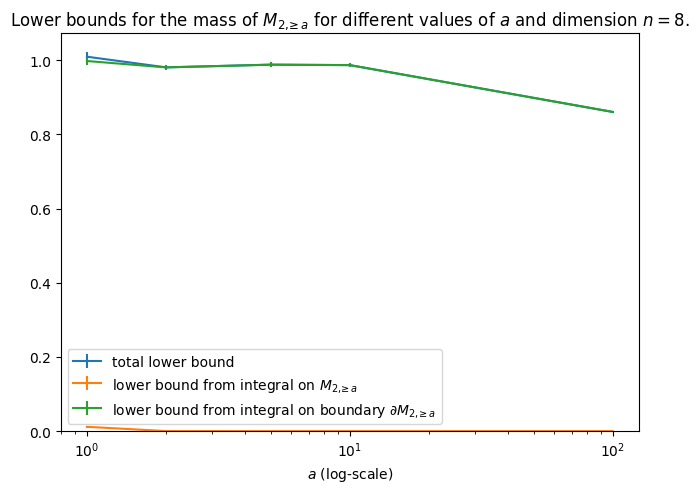

In [ ]:
m_value=r_critical_value**(dim_value-2)*2
plt.errorbar(a_values,total_lower_bounds,yerr=total_errors,label=f"total lower bound")
plt.errorbar(a_values,lower_bounds_M,yerr=errors_M,label=f"lower bound from integral on $ M_{{{m_value},\!\!\geq a}}$")
plt.errorbar(a_values,lower_bounds_boundary,yerr=errors_boundary,label=f"lower bound from integral on boundary $\partial M_{{{m_value},\!\!\geq a}}$")
plt.xscale('log')
plt.gca().set_ylim(bottom=0)
plt.xlabel("$a$ (log-scale)")
# plt.ylabel("lower bound for mass obtained from harmonic function method")
plt.legend()
plt.tight_layout()
plt.title(f"Lower bounds for the mass of $M_{{{m_value},\!\!\geq a}}$ for different values of $a$ and dimension $n={dim_value}$.")
plt.show()

## Plotting the harmonic coordinates

### Plotting Utilities

Matplotlib does not come with a method of plotting implicit surfaces. The following approach is from [answers to this Stack Overflow question](https://stackoverflow.com/questions/4680525/plotting-implicit-equations-in-3d).

```python
# https://stackoverflow.com/a/4687582
def plot_implicit_using_contours(ax,fn,level_set_value=0, bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50,samples=30):
    """ Create a plot of a 2d implicite surface fn(x,y,z)=level_set_value using contours

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
        samples (int, optional): Number of slices to take
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin, xmax, resolution)
    yl = np.linspace(ymin,ymax,resolution)
    zl = np.linspace(zmin, zmax, samples)
    A1, A2 = np.meshgrid(xl,xl)

    for z in zl: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z)-level_set_value
        cset = ax.contour(X, Y, Z+z-level_set_value, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in zl: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z)-level_set_value
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    for x in zl: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z)-level_set_value
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

def plot_implicit_using_marching_cubes(ax,fn,level_set_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
    """ Create a plot of a 2d implicit surface fn(x,y,z)=level_set_value using marching cubes

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin,xmax, resolution)
    yl = np.linspace(ymin,ymax, resolution)
    zl = np.linspace(zmin,zmax, resolution)
    X, Y, Z = np.meshgrid(xl, yl, zl)
    F=fn(X,Y,Z)


    verts, faces, normals, values = measure.marching_cubes(F, level_set_value, spacing=[np.diff(xl)[0],np.diff(yl)[0],np.diff(zl)[0]])
    # need to correct vertex coordinates as they are expressed in Voxel coordinates
    verts += (xmin,ymin,zmin)
    
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces,
                    verts[:, 2], # color
                    cmap='magma',vmin=zmin,vmax=zmax)
    
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)
    return verts, faces
```

```python
def plot_coordinate_level_sets(coordinate,level_set_values=(0),m_value=1,a_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
  fn = sympy.lambdify([x1,x2,x1],(coordinate()).subs(((m,m_value),(a,a_value))))

  n_plots = len(level_set_values)
  n_cols = min(2,n_plots)
  n_rows = (n_plots+1)//2

  fig = plt.figure(figsize=(10,n_rows*4+1))
  fig.suptitle(f"Level sets of ${sympy.latex(coordinate.symbol)}$ on $M_{{{m_value},\!\!\geq {a_value}}}$",fontsize=20,y=0,va="top")

  axes = fig.subplots(ncols=n_cols,nrows=n_rows,subplot_kw=dict(projection='3d'),squeeze=False)

  if n_plots<n_rows*2:
    fig.delaxes(axes[n_rows-1,n_cols-1]) # delete last axis if unneccessary

  for index, level_set_value in enumerate(level_set_values):
    ax = axes.flatten()[index]
    ax.set_title(f"${sympy.latex(coordinate.symbol)}={level_set_value:.2f}$",fontsize=16,pad=0)
    ax.locator_params(nbins=4)
    
    plot_implicit_using_marching_cubes(ax,fn,level_set_value,bbox=bbox,resolution=resolution)
    ax.set_aspect('equal')
  fig.tight_layout(h_pad=5)
  return fig
```

### Plots for $M_{m,+}=M_{m,\geq 0}$

```python
fig=plot_coordinate_level_sets(u1,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],bbox=[(-1.5,1.5),(-1.5,1.5),(0,1.1)])
fig.savefig("../figures/level_sets_u1_unmodified",bbox_inches='tight')
````

```python
plot_coordinate_level_sets(u2,[-0.75,-0.5,-0.25,0,0.25,0.5,0.75],bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.1)])
plt.savefig("../figures/level_sets_u2_unmodified",bbox_inches="tight")
```

### Plots for $M_{m,\!\!\geq a}$. We can symbolically check that the boundary $x_3=a$ is actually a level set. Numerically this level set is not quite correctly computed due to rounding errors.

```python
for a_value in [0.1,0.3]:
  fig=plot_coordinate_level_sets(u1_modified,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])+a_value,a_value=a_value,bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.5)],resolution=100)
  fig.savefig(f'../figures/level_sets_u1_modified_with_a_{a_value}.png',bbox_inches='tight')
```